## 🎧 UrbanSound8K Classification with CNN

This notebook trains a Convolutional Neural Network (CNN) to classify environmental sounds (such as dog barks, car horns, sirens, etc.) using the UrbanSound8K dataset.

 ### Install & Import Dependencies


In [2]:
# Import all necessary libraries for data loading, preprocessing, feature extraction, 
# model building (Keras/TensorFlow), and evaluation/visualization.
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import Audio

# Force inline plotting
%matplotlib inline

### Define Settings and Dataset Paths


In [4]:
# Check environment type (GPU vs TPU)
DEVICE = "GPU" if os.environ.get("COLAB_TPU_ADDR", None) is None else "TPU"
print("Using environment:", DEVICE)

# Base directories
BASE_DIR   = os.path.join(os.getcwd(), "dataset")
CSV_PATH   = os.path.join(BASE_DIR, "UrbanSound8K.csv")
AUDIO_ROOT = BASE_DIR   # expecting fold1…fold10 subfolders here

# Audio processing parameters
SAMPLE_RATE   = 22050  # Sampling rate used for audio files
DURATION_SEC  = 4      # Each clip is truncated/padded to 4 seconds
NUM_SAMPLES   = SAMPLE_RATE * DURATION_SEC   # Total samples per clip
N_MELS        = 168    # Number of mel frequency bins
FIXED_LENGTH  = 168   # Target time-frames for mel-spectrogram
HOP_LENGTH    = 512   # Step size between FFT windows

# Folds used for dataset splitting
TEST_FOLD     = 10
VAL_FOLD      = 9

# # Class names (for plotting / reporting)
CLASS_MAPPING = [
    "air_conditioner", "car_horn", "children_playing", "dog_bark",
    "drilling", "engine_idling", "gun_shot", "jackhammer",
    "siren", "street_music"
]

Using environment: GPU


### Load Metadata and Explore Audio Samples


In [ ]:
# Read metadata file (UrbanSound8K.csv) and build relative paths to audio files

metadata = pd.read_csv(CSV_PATH)

# Use relative paths
metadata['filepath'] = metadata.apply(
    lambda r: os.path.join("dataset", f"fold{r.fold}", r.slice_file_name),
    axis=1
)

metadata


,slice_file_name,fsID,start,end,salience,fold,classID,class,filepath
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark,dataset\fold5\100032-3-0-0.wav
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing,dataset\fold5\100263-2-0-117.wav
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing,dataset\fold5\100263-2-0-121.wav
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing,dataset\fold5\100263-2-0-126.wav
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing,dataset\fold5\100263-2-0-137.wav
...,...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn,dataset\fold7\99812-1-2-0.wav
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn,dataset\fold7\99812-1-3-0.wav
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn,dataset\fold7\99812-1-4-0.wav
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn,dataset\fold7\99812-1-5-0.wav


In [ ]:
# Preview the first few rows of the metadata to understand its structure
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,filepath
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,dataset\fold5\100032-3-0-0.wav
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,dataset\fold5\100263-2-0-117.wav
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,dataset\fold5\100263-2-0-121.wav
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,dataset\fold5\100263-2-0-126.wav
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,dataset\fold5\100263-2-0-137.wav


In [ ]:
# Check class distribution to see if the dataset is balanced
metadata.groupby('class').slice_file_name.count()

class
air_conditioner     1000
car_horn             429
children_playing    1000
dog_bark            1000
drilling            1000
engine_idling       1000
gun_shot             374
jackhammer          1000
siren                929
street_music        1000
Name: slice_file_name, dtype: int64

In [ ]:
from IPython.display import Audio, display

# Listen to a sample audio clip from the dataset
file_path = "Dataset/fold7/101848-9-0-0.wav"  

#file_path = "Dataset/fold1/7383-3-1-0.wav"
#file_path = "Dataset/fold4/14110-4-0-0.wav"


display(Audio(file_path))

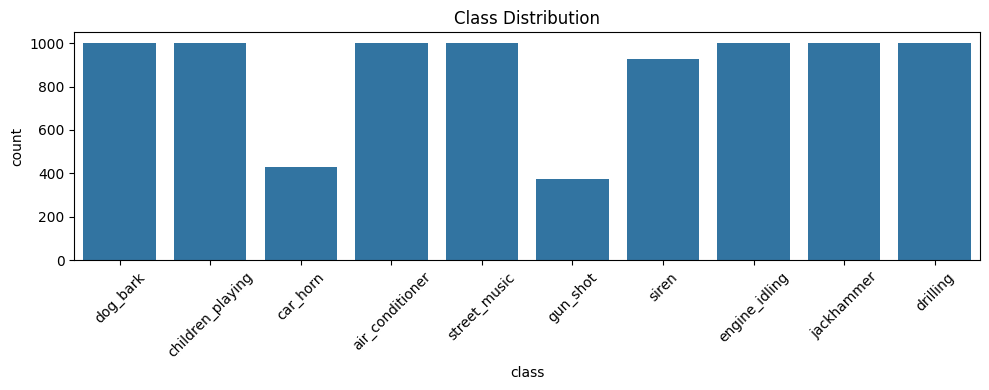

In [ ]:
#  Plot class distribution
plt.figure(figsize=(10,4))
#sns.countplot(x='class', data=metadata, order=metadata['class'].value_counts().index)
sns.countplot(x='class', data=metadata)
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.tight_layout()
plt.show()

### Waveform and Mel-Spectrogram Examples

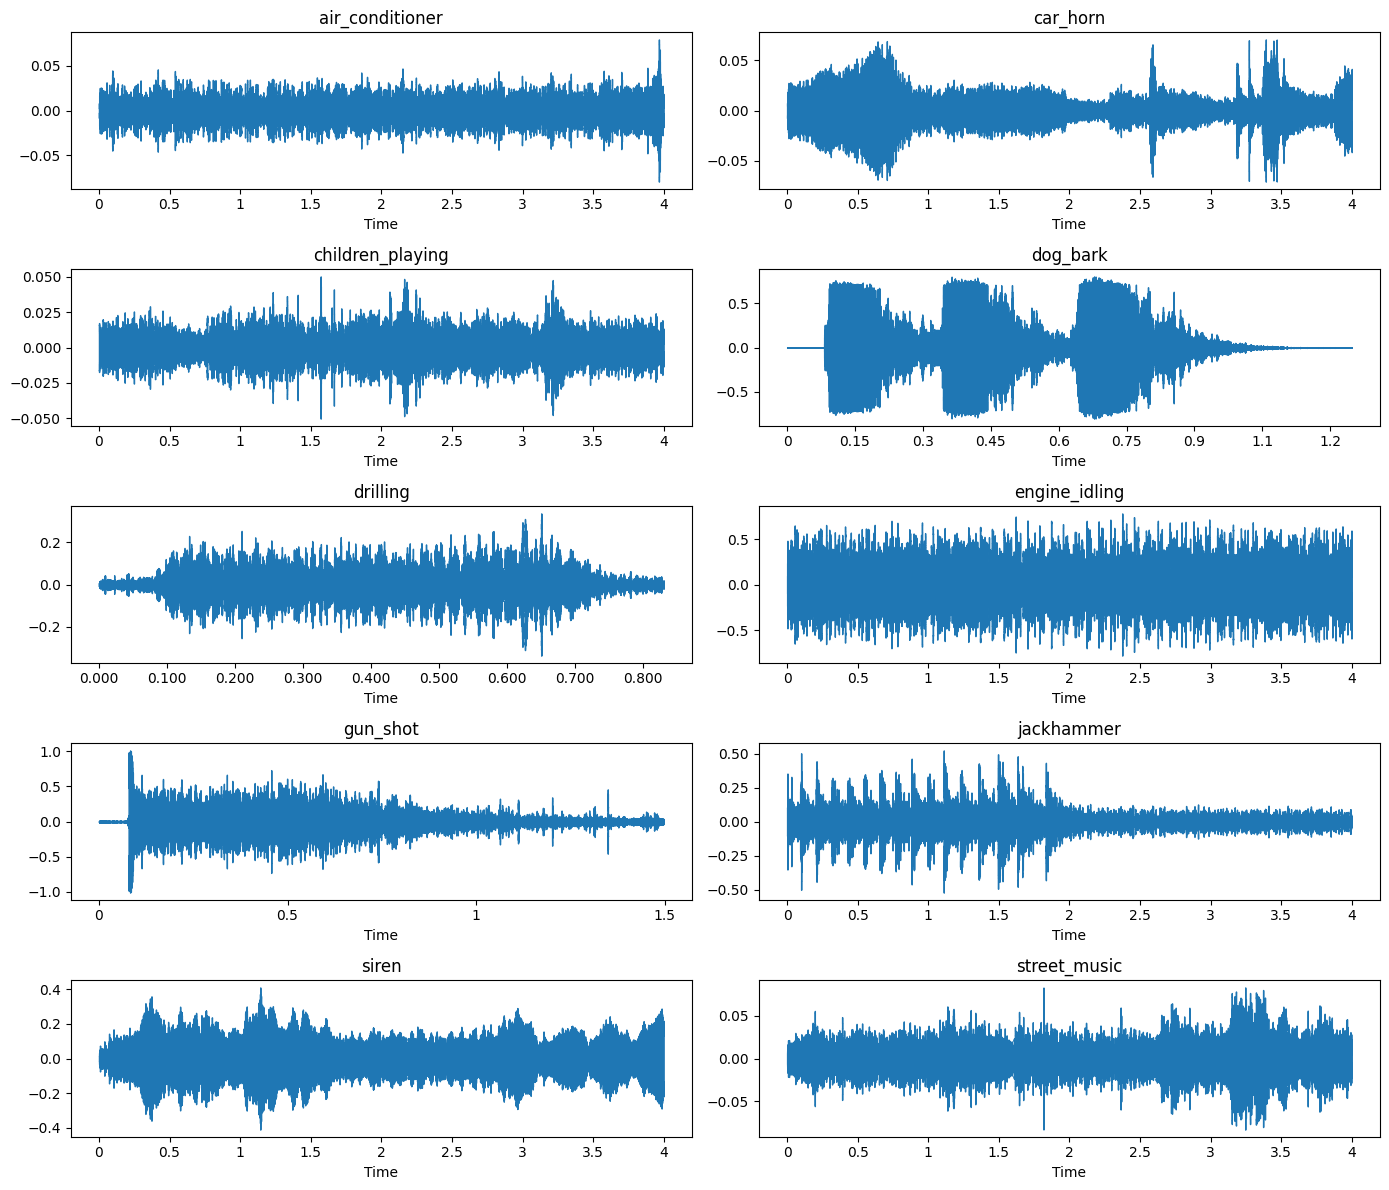

In [ ]:
import warnings
# Ignore specific DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Pick one random example per class to visualize
# This helps compare the waveform and Mel-spectrograms between sound classes
sampled = metadata.groupby('class').apply(lambda grp: grp.sample(1, random_state=42)).reset_index(drop=True)

# Plot waveforms in a 5x2 grid
fig, axs = plt.subplots(5, 2, figsize=(14, 12))
axs = axs.flatten()
for idx, row in sampled.iterrows():
     # Load audio clip using relative path
    y, sr = librosa.load(row.filepath, sr=SAMPLE_RATE, mono=True)
    librosa.display.waveshow(y, sr=sr, ax=axs[idx])
    axs[idx].set_title(row['class'])
plt.tight_layout()
plt.show()


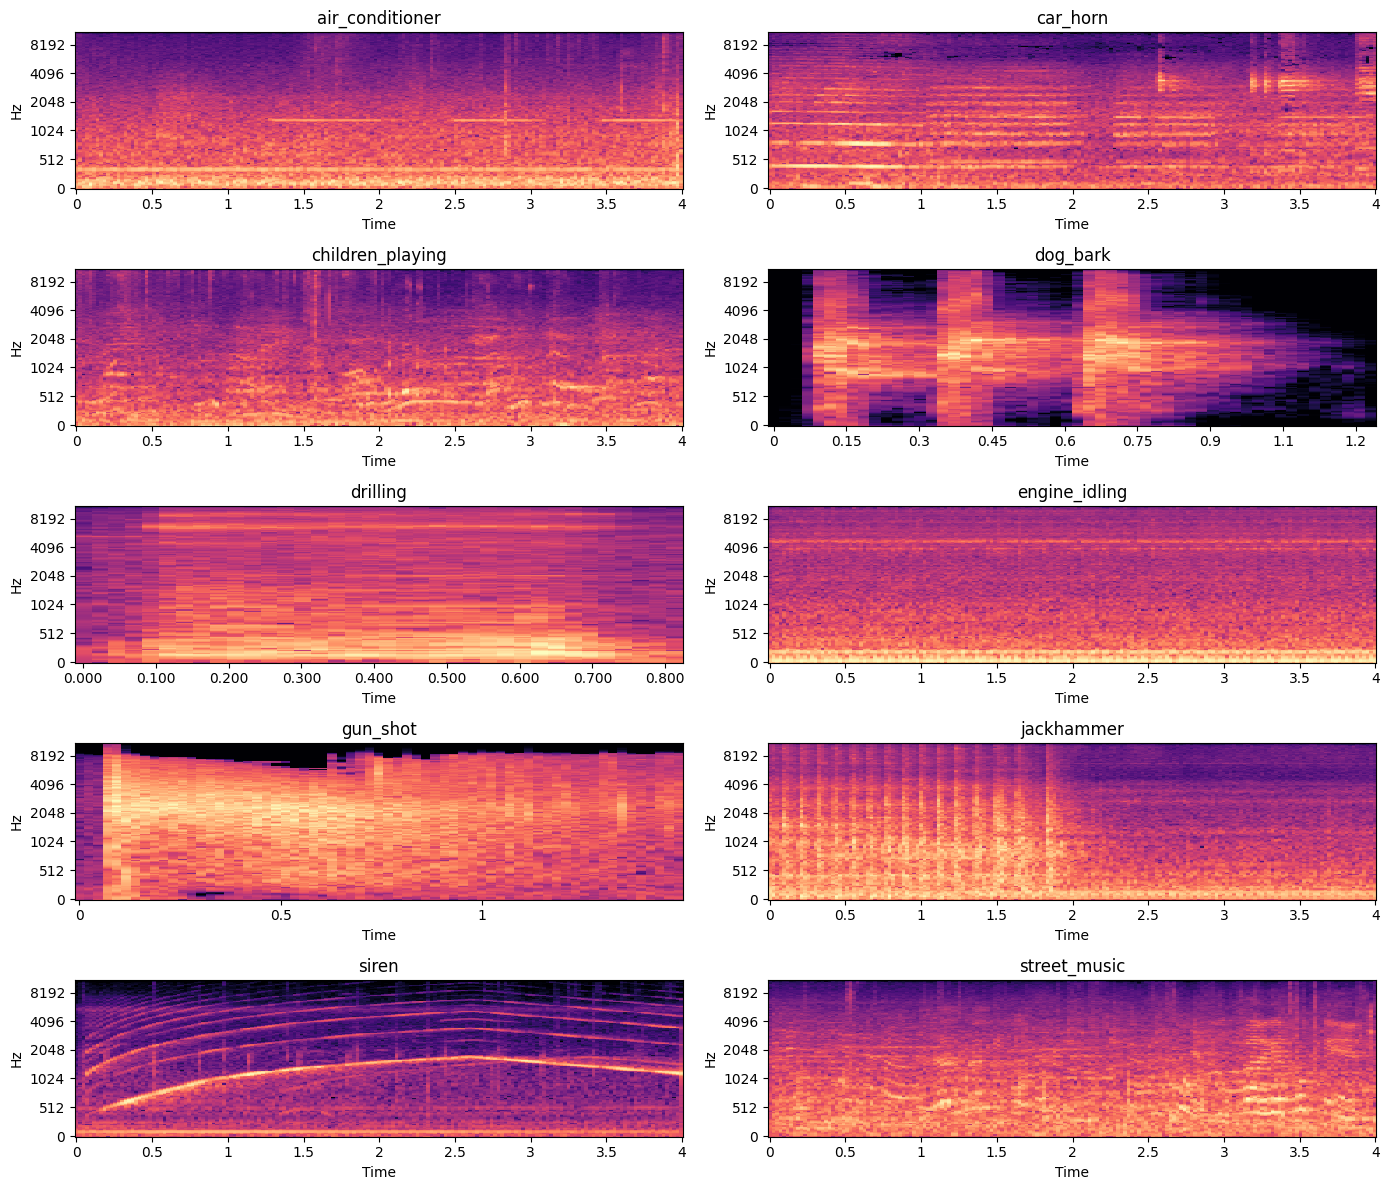

In [ ]:
# Plot Mel-spectrograms for one sample per class in a 5x2 grid
# Mel-spectrograms provide a time-frequency representation of the audio, which is commonly used as input for CNN models in audio classification
fig, axs = plt.subplots(5, 2, figsize=(14, 12))
axs = axs.flatten()
for idx, row in sampled.iterrows():
    # Load audio clip using relative path
    y, sr = librosa.load(row.filepath, sr=SAMPLE_RATE, mono=True)
    # Compute Mel-spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024,
                                       hop_length=HOP_LENGTH, n_mels=N_MELS)
    S_db = librosa.power_to_db(S, ref=np.max)
    # Display Mel-spectrogram
    librosa.display.specshow(S_db, sr=sr, hop_length=HOP_LENGTH,
                             x_axis='time', y_axis='mel', ax=axs[idx])
    axs[idx].set_title(row['class'])
plt.tight_layout()
plt.show()

### Feature Extraction — Compute Mel-Spectrograms

In [ ]:
def extract_mel_spectrogram(file_path, n_mels=N_MELS, fixed_length=FIXED_LENGTH,
                            sr=SAMPLE_RATE, hop_length=HOP_LENGTH):
    """
   Load an audio file and compute a log-Mel spectrogram suitable for CNN input.

    Steps:
    1. Load audio in mono at the target sampling rate.
    2. Trim or pad to a fixed length (NUM_SAMPLES) for uniform input size.
    3. Compute Mel-spectrogram and convert to decibel scale.
    4. Ensure the spectrogram has a fixed number of time frames (fixed_length).

    Returns:
        mel_db (np.ndarray): Mel-spectrogram of shape (n_mels, fixed_length), dtype float32.
    """
    try:
        # Load audio
        audio, _ = librosa.load(file_path, sr=sr, mono=True)
        # Trim or pad to exact NUM_SAMPLES
        if len(audio) > NUM_SAMPLES:
            audio = audio[:NUM_SAMPLES]
        else:
            audio = np.pad(audio, (0, max(0, NUM_SAMPLES - len(audio))), mode='constant')
        # Compute Mel-spectrogram
        mel = librosa.feature.melspectrogram(y=audio, sr=sr,
                                             n_fft=1024, hop_length=hop_length,
                                             n_mels=n_mels, fmax=sr//2)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        # Ensure the spectrogram has fixed number of time frames
        if mel_db.shape[1] > fixed_length:
            mel_db = mel_db[:, :fixed_length]
        elif mel_db.shape[1] < fixed_length:
            mel_db = np.pad(mel_db, ((0,0), (0, fixed_length - mel_db.shape[1])), mode='constant')
        return mel_db
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros((n_mels, fixed_length), dtype=np.float32)


### Split Dataset and Prepare Train/Validation/Test Sets

In [ ]:
# Split metadata by folds (UrbanSound8K uses 10 folds)
# Folds 1–8: training, fold 9: validation, fold 10: testing
train_df = metadata[metadata['fold'].isin(range(1, VAL_FOLD))].reset_index(drop=True)  # folds 1–8
val_df   = metadata[metadata['fold'] == VAL_FOLD].reset_index(drop=True)               # fold 9
test_df  = metadata[metadata['fold'] == TEST_FOLD].reset_index(drop=True)              # fold 10

print(f"Train samples: {len(train_df)} | Val samples: {len(val_df)} | Test samples: {len(test_df)}")

#  Extract mel-spectrograms and labels for each subset
def prepare_data(df):
    X_list, y_list = [], []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        mel_spec = extract_mel_spectrogram(row.filepath)
        X_list.append(mel_spec)
        y_list.append(int(row.classID))
    X_arr = np.stack(X_list, axis=0).astype(np.float32)   # shape (N, n_mels, fixed_length)
    # normalize to roughly range [-1, 1]
    mean_val = X_arr.mean()
    std_val  = X_arr.std()
    X_norm   = (X_arr - mean_val) / (std_val + 1e-8)
    # add channel dimension
    X_norm = X_norm[..., np.newaxis]   # shape (N, n_mels, fixed_length, 1)
    y_cat = to_categorical(y_list, num_classes=len(CLASS_MAPPING))
    return X_norm, y_cat

X_train, y_train = prepare_data(train_df)
X_val,   y_val   = prepare_data(val_df)
X_test,  y_test  = prepare_data(test_df)

print(f"X_train shape: {X_train.shape} | y_train shape: {y_train.shape}")
print(f"X_val   shape: {X_val.shape}   | y_val   shape: {y_val.shape}")
print(f"X_test  shape: {X_test.shape}  | y_test  shape: {y_test.shape}")


Train samples: 7079 | Val samples: 816 | Test samples: 837


  0%|          | 0/7079 [00:00<?, ?it/s]

100%|██████████| 837/837 [00:24<00:00, 34.14it/s]


X_train shape: (7079, 168, 168, 1) | y_train shape: (7079, 10)
X_val   shape: (816, 168, 168, 1)   | y_val   shape: (816, 10)
X_test  shape: (837, 168, 168, 1)  | y_test  shape: (837, 10)


### Build and Compile the CNN Model

In [ ]:
# Define a sequential CNN architecture for audio classification.
# Each block: Conv2D + BatchNorm + MaxPooling
# Dense layers with Dropout at the end for regularization.

num_classes = len(CLASS_MAPPING)

model = Sequential([
    Input(shape=(N_MELS, FIXED_LENGTH, 1)),

    # Block 1
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Block 2
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Block 3
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Block 4
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.summary() # Display model structure and parameter count


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 168, 168, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 168, 168, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 84, 84, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 84, 84, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 84, 84, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 42, 42, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 42, 42, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 21, 21, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,553,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,977,802 (26.62 MB)

 Trainable params: 6,976,842 (26.61 MB)

 Non-trainable params: 960 (3.75 KB)

### Train the Model with Early Stopping and Learning Rate Scheduler

In [ ]:
# EarlyStopping: stops training if val_loss doesn't improve for 5 epochs
# ReduceLROnPlateau: reduces learning rate if validation loss plateaus

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5,
                               min_lr=1e-6, verbose=1)

# The model is trained for up to 30 epochs, EarlyStopping will stop training sooner if no improvement is observed
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

BASE_PROJECT_DIR = os.getcwd()
MODELS_DIR       = os.path.join(BASE_PROJECT_DIR, "models")
os.makedirs(MODELS_DIR, exist_ok=True)
model_path = os.path.join(MODELS_DIR, "urbansound8k_keras_cnn.h5")
model.save(model_path) # Save the trained model for future inference or evaluation

Epoch 1/30
222/222 ━━━━━━━━━━━━━━━━━━━━ 548s 2s/step - accuracy: 0.1963 - loss: 4.8586 - val_accuracy: 0.1225 - val_loss: 29.7708 - learning_rate: 0.0010
Epoch 2/30
222/222 ━━━━━━━━━━━━━━━━━━━━ 511s 2s/step - accuracy: 0.2372 - loss: 2.1344 - val_accuracy: 0.1850 - val_loss: 30.3051 - learning_rate: 0.0010
Epoch 3/30
222/222 ━━━━━━━━━━━━━━━━━━━━ 523s 2s/step - accuracy: 0.3094 - loss: 1.9856 - val_accuracy: 0.3444 - val_loss: 2.8288 - learning_rate: 0.0010
Epoch 4/30
222/222 ━━━━━━━━━━━━━━━━━━━━ 407s 2s/step - accuracy: 0.3380 - loss: 1.8756 - val_accuracy: 0.4350 - val_loss: 1.6220 - learning_rate: 0.0010
Epoch 5/30
222/222 ━━━━━━━━━━━━━━━━━━━━ 476s 2s/step - accuracy: 0.3679 - loss: 1.8682 - val_accuracy: 0.5453 - val_loss: 1.5160 - learning_rate: 0.0010
Epoch 6/30
222/222 ━━━━━━━━━━━━━━━━━━━━ 423s 2s/step - accuracy: 0.4209 - loss: 1.5926 - val_accuracy: 0.4105 - val_loss: 1.7838 - learning_rate: 0.0010
Epoch 7/30
222/222 ━━━━━━━━━━━━━━━━━━━━ 398s 2s/step - accuracy: 0.4857 - loss: 

### Evaluate Model on Test Set


In [ ]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss*100:.2f}%")

# Retrieve final training and validation performance (from last epoch)
train_acc = history.history['accuracy'][-1]  
val_acc = history.history['val_accuracy'][-1] 

print(f"Train Accuracy: {train_acc*100:.2f}%")
print(f"Validation Accuracy: {val_acc*100:.2f}%")

27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 322ms/step - accuracy: 0.7361 - loss: 0.7758
Test Accuracy: 73.72%
Test Loss: 85.11%
Train Accuracy: 90.62%
Validation Accuracy: 79.66%


### Visualize Training Progress (Loss and Accuracy)

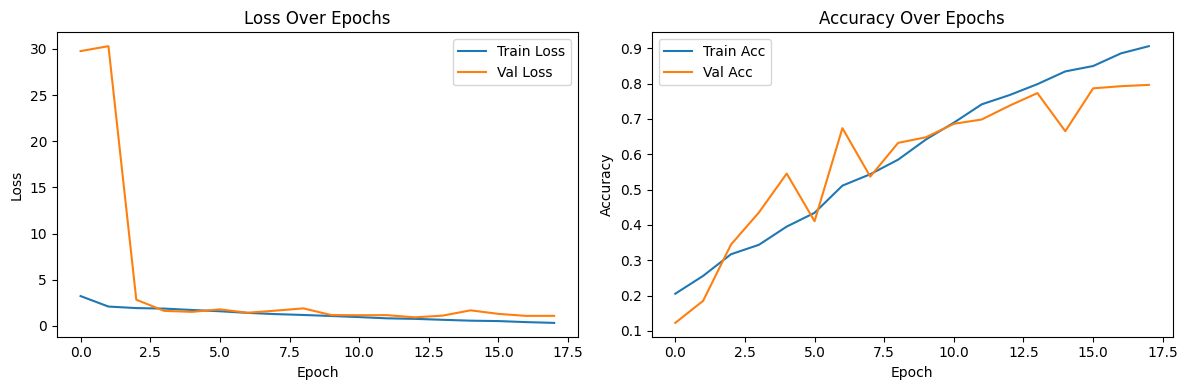

In [ ]:
# Plot how the model's loss and accuracy evolved during training
plt.figure(figsize=(12,4))

# Plot training vs validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot training vs validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


### Confusion Matrix and Classification Report


27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 322ms/step - accuracy: 0.7361 - loss: 0.7758

Test Accuracy: 73.72% | Test Loss: 0.8511
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 303ms/step


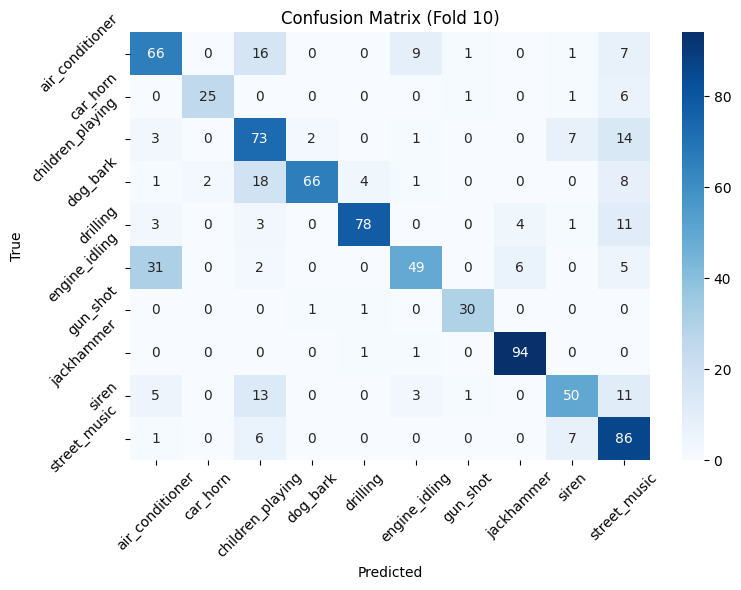


Classification Report:
                  precision    recall  f1-score   support

 air_conditioner       0.60      0.66      0.63       100
        car_horn       0.93      0.76      0.83        33
children_playing       0.56      0.73      0.63       100
        dog_bark       0.96      0.66      0.78       100
        drilling       0.93      0.78      0.85       100
   engine_idling       0.77      0.53      0.62        93
        gun_shot       0.91      0.94      0.92        32
      jackhammer       0.90      0.98      0.94        96
           siren       0.75      0.60      0.67        83
    street_music       0.58      0.86      0.69       100

        accuracy                           0.74       837
       macro avg       0.79      0.75      0.76       837
    weighted avg       0.77      0.74      0.74       837



In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest Accuracy: {test_acc*100:.2f}% | Test Loss: {test_loss:.4f}")

# Confusion matrix shows where the model confuses classes
# Classification report includes precision, recall, and F1-score per class

# Predict probabilities and labels for test set
y_pred_probs  = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
# Plot confusion matrix heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_MAPPING,
            yticklabels=CLASS_MAPPING)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Fold 10)")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Print detailed per-class metrics
print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=CLASS_MAPPING))


### ROC and Precision-Recall Curves (Multi-class Evaluation)


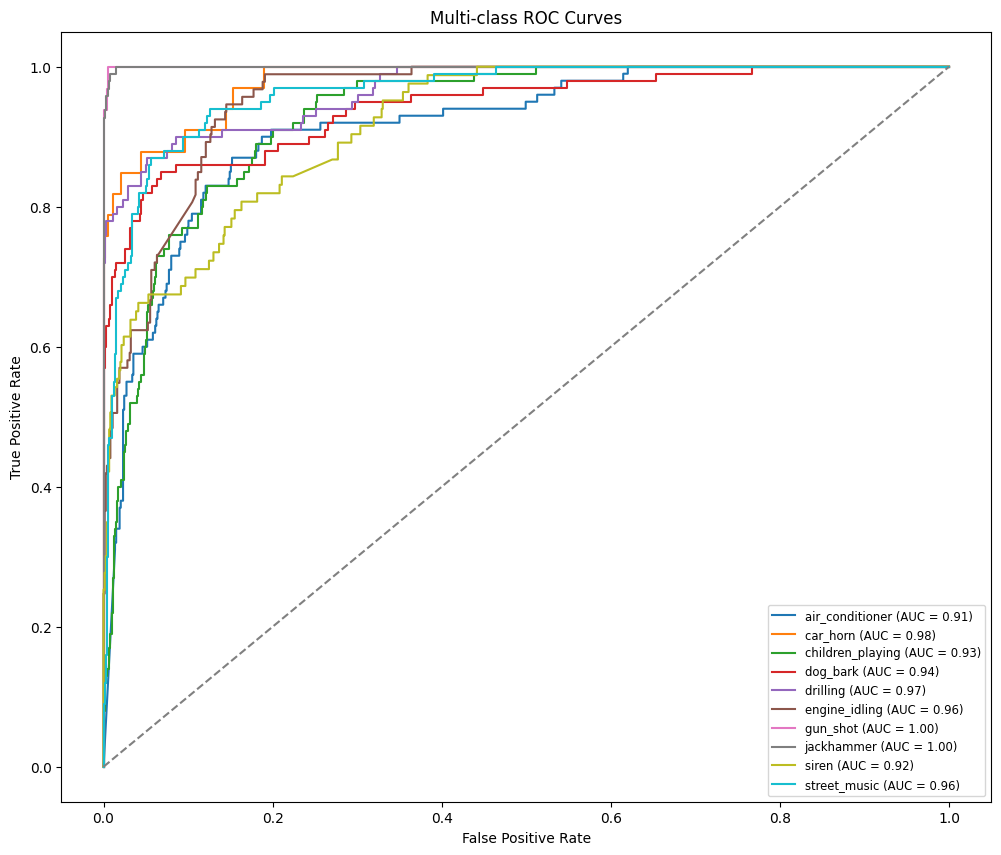

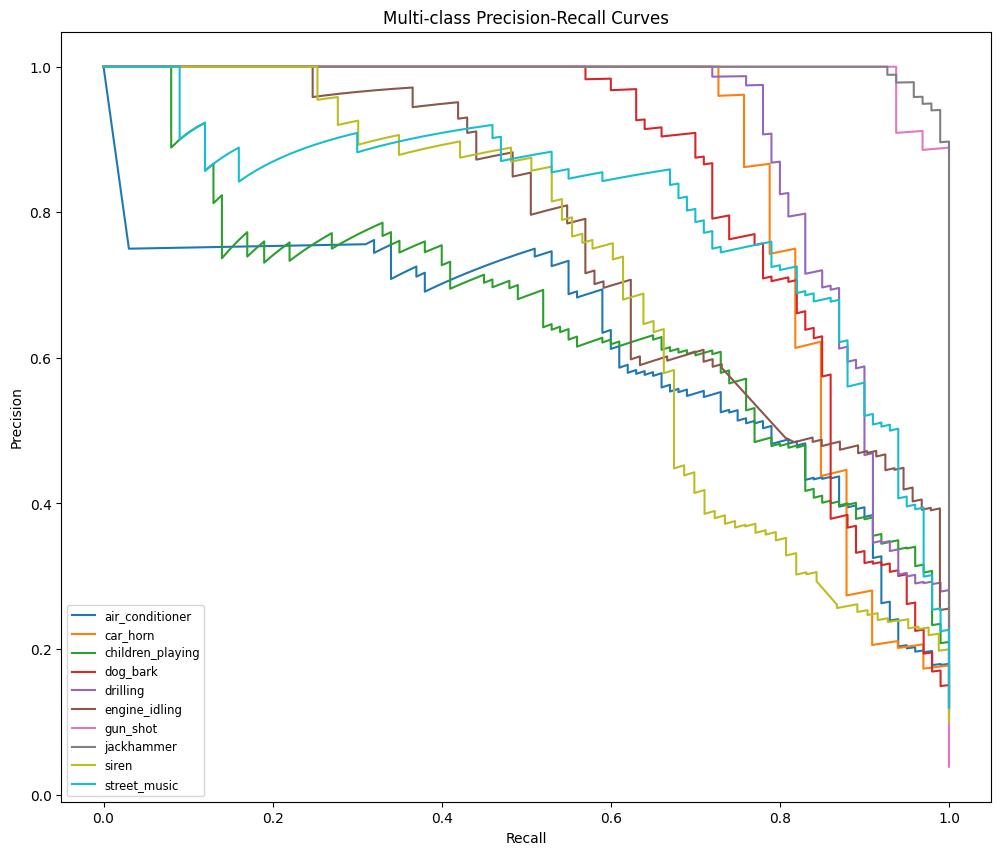

In [ ]:
# These plots help visualize how well the model separates classes
# and how confident it is in its predictions for each sound category

# Binarize true labels for multi-class
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(y_true_labels)  # shape (N_test, num_classes)

#  ROC CURVES
plt.figure(figsize=(12, 10))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{CLASS_MAPPING[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.title('Multi-class ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize='small')
plt.show()

#  PRECISION-RECALL CURVES
plt.figure(figsize=(12, 10))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, label=CLASS_MAPPING[i])

plt.title('Multi-class Precision-Recall Curves')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left', fontsize='small')
plt.show()